## Andreas Tsantilas Shabani Team No.1

In [7]:
from qiskit import *
from qiskit.circuit import *
from qiskit.extensions import RYGate
import math
import numpy as np
import matplotlib.pyplot as plt
from qiskit.providers.aer import *
from qiskit.quantum_info import *
from qiskit.ignis.verification import*

qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}

In [8]:
def g_(sigma_, mu_, lim):
    # normalization function, equal to psi tilde squared, summed over all the integers.
    # in lieu of an infinite sum, we can simply make ``lim" sufficiently high. 
    return np.sum(np.exp((-(np.arange(-lim, lim+1, 1) - mu_)**2)/float((2)*sigma_**2)))

def angle_(sigma_, mu_, lim=10**3):
    # Calculates the angle, based on the square root of probability. 
    # cutoff the infinite sum in g_(...) at 10**3 by default
    return np.arccos(np.sqrt(g_(sigma_/2., mu_/2., lim)/g_(sigma_, mu_, lim)))

def ctrl_states(n):
    states = []
    for i in range(0,2**n):
        s = bin(i).replace("0b", "")
        states.append("".join(["0" for j in range(0,n-len(s))])+s)
    return states

def new_mu(qub, mu):
    # calculate modified \mu for n-bit string qubit
    # i.e., we have g(b, mu) = (mu - b)/2, b \in {0,1}, and g('',mu) = mu
    # e.g., h('101101', mu) = g('1',g('0',g('1',g(...)))) etc.
    new_mean = mu
    for bit in qub[::-1]:#reversed because we consider the qubits increasingly further back
        new_mean = (new_mean/2.) - ((1/2.)*int(bit))
    return new_mean

In [9]:
def create_circ(N, mu_, sig_,):
    qr = QuantumRegister(N, 'q')
    qc = QuantumCircuit(qr)# Generate a quantum circuit with a quantum register (list) of qubit objects
    alpha_0 = angle_(sig_, mu_) # We multiply by 2, because the ry gate rotates by alpha/2
    qc.ry(2*alpha_0,0) # apply a rotation angle of alpha_0 (multiply by 2 because gate halves parameter)
    for i in range(1,N): # Steps to be done at level q_i
        qstring = ctrl_states(i) # create list of 2^i strings of length i
        for k in qstring:
            alpha_ = angle_(sig_/(2**i), new_mu(k, mu_)) # Calculate angle using modified mean
            new_gate = RYGate(2*alpha_).control(num_ctrl_qubits = i, 
                                                label = None, 
                                                ctrl_state=k) # control state is 
            qc.append(new_gate, qr[:i+1]) # add ry gate to level

    return qc

In [ ]:
def gaussian(x,a,b,c,baseline=0):
    return a*np.exp(-(x-b)**2/(2*c**2)) + baseline



## This is a noiseless simulation of the Gaussian with parameters $\mu$ and $\sigma$.

[0.0008254  0.00284598 0.00831998 0.02062233 0.04333889 0.0772222
 0.11666244 0.14943227 0.16228642 0.14943227 0.11666244 0.0772222
 0.04333889 0.02062233 0.00831998 0.00284598]
theory = [0.0008253999652749822,0.0028459751412894013,0.008319978504747774,0.020622330942862914,0.04333888618314278,0.07722220266857246,0.11666244404563876,0.14943227273737988,0.16228641958745693,0.14943227273737988,0.11666244404563876,0.07722220266857246,0.04333888618314278,0.020622330942862914,0.008319978504747774,0.0028459751412894013]


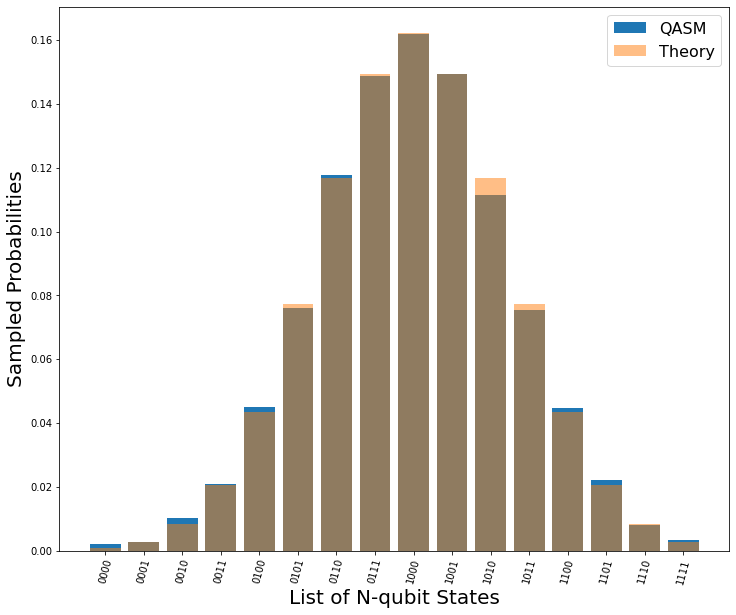

In [59]:
N = 4
sigma = 2**N/6.5
mu = 2**(N-1)

qc = create_circ(N,mu,sigma)
qc.measure_all()


backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend, shots=8192).result().get_counts()
rez = sorted(result.items())

x = np.arange(2**N)
y = gaussian(x,1,(2**N)//2,sigma,0)

y = y/sum(y)

labels, counts = zip(*rez)

counts = counts/np.sum(counts)

print(y)

quad_deviation = sum((xi-yi)**2 for xi,yi in zip(counts,y))/(N-1)
print('theory = [' + ','.join(str(i) for i in y)+']')

plt.figure(figsize=(12, 10))
plt.xticks(rotation=75)
plt.bar(labels, counts, label='QASM')
plt.bar(labels, y, alpha=.5, label='Theory')

plt.legend(prop={'size': 16})
plt.xlabel('List of N-qubit States',fontsize=20)
plt.ylabel('Sampled Probabilities',fontsize=20)
plt.show()


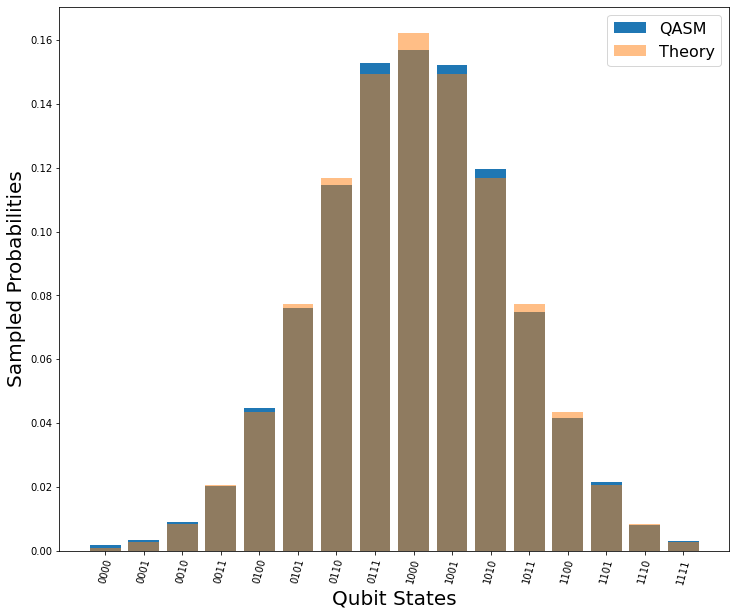

In [53]:
N = 4
sigma = 2**N/6.5
mu = 2**(N-1)

qc = create_circ(N,mu,sigma)
qc.measure_all()

backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend, shots=8192).result().get_counts()
rez = sorted(result.items())

x = np.arange(2**N)
y = gaussian(x,1,(2**N)//2,sigma,0)

y = y/sum(y)

labels, counts = zip(*rez)

counts = counts/np.sum(counts)

plt.figure(figsize=(12, 10))
plt.xticks(rotation=75)
plt.bar(labels, counts, label='QASM')
plt.bar(labels, y, alpha=.5, label='Theory')

plt.legend(prop={'size': 16})
plt.xlabel('Qubit States',fontsize=20)
plt.ylabel('Sampled Probabilities',fontsize=20)
plt.show()


## We now measure goodness-of-fit

Amplitude 565.6278579609618 +/- 644388.7904833081
Center 5.987154818948766 +/- 0.23775202105598053
Width 8.050861309090417 +/- 55.02215049812326
Baseline 32.991134446399684 +/- 662832.0485808679


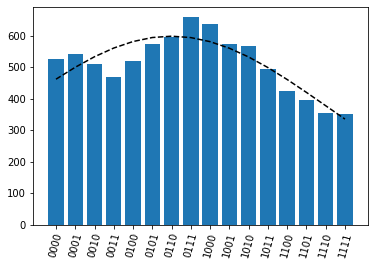

In [30]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def gaussian(x,a,b,c,baseline):
    return a*np.exp(-(x-b)**2/(2*c**2)) + baseline

def fit_gaussian(counts):
    x = np.arange(len(counts))
    return curve_fit(gaussian,x,counts)
    
    
def plot_and_print_fitted_results(labels,counts):
    test_data = result2
    labels, counts = zip(*sorted(test_data.items()))

    popt, pcov = fit_gaussian(counts)

    variables = ['Amplitude','Center', 'Width', 'Baseline']

    for i,variable in enumerate(variables):
        print(variable,popt[i],'+/-',pcov[i,i])

    x = np.arange(len(counts))
    y = gaussian(x,*popt)

    plt.xticks(rotation=75)
    plt.bar(labels,counts)
    plt.plot(x,y,'k--')
    
test_data = result
labels, counts = zip(*sorted(test_data.items()))

plot_and_print_fitted_results(labels,counts)

## This is a simulation performed on 'ibmq_rome'. Results are best when no coupling map is specified. This defaults to None which seems to eliminate a lot of the noise. Feel free to replace the backend and toy around with some parameters.


<Figure size 432x288 with 0 Axes>

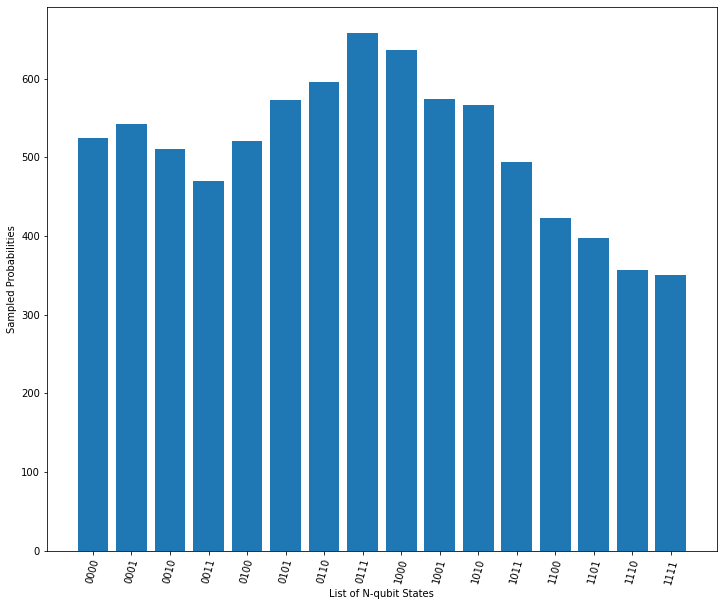

{'01110': 580, '10111': 249, '00001': 11, '10010': 661, '10100': 502, '11011': 66, '00100': 38, '01100': 430, '01001': 228, '00011': 17, '11101': 22, '11100': 35, '11111': 9, '10101': 435, '11000': 182, '01111': 626, '00101': 47, '01101': 537, '00110': 84, '11001': 123, '10110': 331, '00010': 21, '01000': 153, '01010': 307, '01011': 399, '10001': 630, '10011': 549, '11010': 83, '10000': 699, '00111': 117, '11110': 19, '00000': 2}


In [23]:
from qiskit import QuantumCircuit, execute
from qiskit import IBMQ, Aer
from qiskit.visualization import plot_histogram
#from qiskit.exceptions import IBMQAccountCredentialsNotFound
import qiskit.providers.aer.noise as noise

try:
    IBMQ.disable_account()
except: # bad practive, aimed to catch IBMQAccountCredentialsNotFound, but I cannot find where this error gets imported from
    pass
provider = IBMQ.enable_account('acddebb030e0ef14799703e4ce5353bbd218287d8aeeb491d5194cefc5768e183f0fede81f60ccecad05e3ed98d20053094c589196ba178186282e574cd54fd2')

backend = provider.get_backend('ibmq_burlington')
noise_model = noise.NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map
#coupling_map = [[0,1],[1,0],[1,2],[2,1], [2,3],[3,2],[3,4],[4,3],[4,0],[0,4]]



# Get basis gates from noise model
basis_gates = noise_model.basis_gates

N = 4
sigma = 2**N/6.5
mu = 2**(N-1)

qc = create_circ(N,mu,sigma)
qc.measure_all()

# Perform a noise simulation
result2 = execute(qc, Aer.get_backend('qasm_simulator'), shots = 8192,
                 coupling_map=None, #coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model).result().get_counts()



rez2 = sorted(result2.items())

labels, counts = zip(*rez2)

plt.clf()

plt.figure(figsize=(12, 10))
plt.xticks(rotation=75)
plt.bar(labels, counts)
plt.xlabel('List of N-qubit States')
plt.ylabel('Sampled Probabilities')
plt.show()

print(result)

Amplitude 565.6278579609618 +/- 644388.7904833081
Center 5.987154818948766 +/- 0.23775202105598053
Width 8.050861309090417 +/- 55.02215049812326
Baseline 32.991134446399684 +/- 662832.0485808679


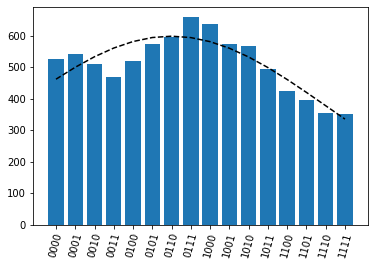

In [27]:
test_data = result2
labels, counts = zip(*sorted(test_data.items()))

popt, pcov = fit_gaussian(counts)

variables = ['Amplitude','Center', 'Width', 'Baseline']

for i,variable in enumerate(variables):
    print(variable,popt[i],'+/-',pcov[i,i])

x = np.arange(len(counts))
y = gaussian(x,*popt)

plt.xticks(rotation=75)
plt.bar(labels,counts)
plt.plot(x,y,'k--')

## Next, we may consider a custom circuit, which allows us to isolate each type of error. We can observe its effects on the Gaussian:


<Figure size 432x288 with 0 Axes>

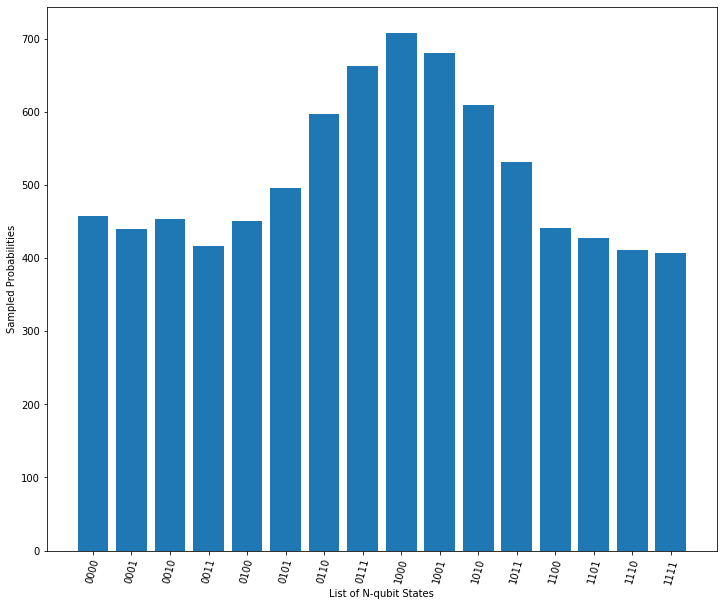

{'11111': 7, '11000': 165, '10010': 610, '11011': 53, '10110': 301, '00100': 27, '10011': 525, '00011': 26, '01010': 325, '01101': 551, '10100': 475, '00111': 128, '11101': 21, '00010': 9, '11100': 42, '10000': 676, '11110': 6, '10101': 394, '01111': 638, '01011': 395, '00001': 7, '00110': 88, '10001': 676, '01110': 627, '00000': 4, '10111': 261, '01001': 241, '11001': 134, '11010': 97, '00101': 52, '01100': 461, '01000': 170}


In [80]:
# Depolarizing Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate

# Qubit reset probabilities
prob_3 = .7
prob_4 = .3

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Qubit reset errors
error_3 = noise.reset_error(prob_3, prob_4)
error_4 = noise.reset_error(prob_3, prob_4)



noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])


# Get basis gates from noise model
basis_gates = noise_model.basis_gates

N = 4
sigma = 2**N/6.5
mu = 2**(N-1)

qc = create_circ(N,mu,sigma)
qc.measure_all()

# Perform a noise simulation
result3 = execute(qc, Aer.get_backend('qasm_simulator'), shots = 8192,
                 coupling_map=None,
                 basis_gates=basis_gates,
                 noise_model=noise_model).result().get_counts()



rez3 = sorted(result3.items())

labels, counts = zip(*rez3)

plt.clf()

plt.figure(figsize=(12, 10))
plt.xticks(rotation=75)
plt.bar(labels, counts)
plt.xlabel('List of N-qubit States')
plt.ylabel('Sampled Probabilities')
plt.show()

print(result)

Amplitude Variance 765.6714761256494
Center  Variance 0.20515784408028354
Width Variance 0.6341710356002096


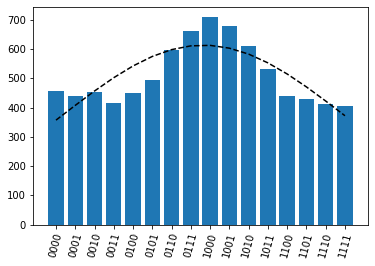

In [81]:
test_data = result3
labels, counts = zip(*sorted(test_data.items()))

popt, pcov = fit_gaussian(counts)

print('Amplitude Variance',pcov[0,0])
print('Center  Variance',pcov[1,1])
print('Width Variance',pcov[2,2])

x = np.arange(len(counts))
y = gaussian(x,*popt)

plt.xticks(rotation=75)
plt.bar(labels,counts)
plt.plot(x,y,'k--')

In [31]:
np.array([0.0112,0.121,0.108])/16

array([0.0007   , 0.0075625, 0.00675  ])